# TenSEAL - biblioteka python do szyfrowania homomorficznego

TenSEAL to biblioteka pythona oparta na Microsoft SEAL. Została zaprojektowana z myślą o łatwym integrowaniu homomorficznego szyfrowania z uczeniem maszynowym, głównie z użyciem PyTorch i obsługuje dwa schematy szyfrowania homomorficznego: BFV i CKKS.

W celu instalacji `tenseal` należy odkomentować poniższą linijkę kodu. Użytkownicy MAC - https://github.com/OpenMined/TenSEAL/issues/451

In [1]:
#pip install tenseal
#!pip install tenseal 

## Budowa kontekstu BFV

`TenSEALContext` to obiekt, który przechowuje klucze i parametry szyfrowania. Po wybraniu schematu szyfrowania `TenSEALContext` tworzymy raz, przed wykonaniem wszelkich homomorficznych obliczeń. Składnia w przypadku BFV to:

`tenseal.context(ts.SCHEME_TYPE_BFV, poly_modulus_degree, plain_modulus)`

gdzie:
- `poly_modulus_degree` to stopień wielomianu $X^n+1$ w pierścieniu $R_q$ (musi być potęgą dwójki, co najmniej $2^{12}$)
- `plain_modulus` to podstawa modularna plaintekstu. Musi spełniać równanie $$\text{plain\_modulus} = 1 \bmod (2 \cdot \text{poly\_modulus\_degree})$$


In [1]:
import tenseal as ts

context_bfv = ts.context(ts.SCHEME_TYPE.BFV,
                         poly_modulus_degree=2**12,
                         plain_modulus=1032193)

context_bfv.generate_galois_keys() #generowanie kluczy

## Szyfrowanie/deszyfrowanie BFV

Funkcja szyfrująca to `tenseal.bfv_vector()`. Przy szyfrowaniu wystarczy podać kontekst i wektor plaintextu. Deszyfrujemy atrybutem `decrypt()`.

In [2]:
m = [1,2,3,4,5]

c = ts.bfv_vector(context_bfv,m)
mm = c.decrypt()

print(mm)

[1, 2, 3, 4, 5]


## Ćwiczenie 1.

Sprawdź głębokość operacji dodawania `+` i mnożenia `*` szyfrogramów otrzymanych z BFV.

In [3]:
import tenseal as ts

cipher_base = ts.bfv_vector(context_bfv, m)
n = len(m)

def depth_limit(ct_base, op="add", *, max_iters=1000):
    ct = (
        ts.bfv_vector(context_bfv, [0] * n)
        if op == "add"
        else ts.bfv_vector(context_bfv, [1] * n)
    )
    exact = [0] * n if op == "add" else [1] * n

    for depth in range(1, max_iters + 1):
        if op == "add":
            ct += ct_base
            exact = [e + x for e, x in zip(exact, m)]
        else:
            ct *= ct_base
            exact = [e * x for e, x in zip(exact, m)]

        if ct.decrypt() != exact:
            return depth
    return f"> {max_iters}"


print(f"Additions fail at depth : {depth_limit(cipher_base, 'add')}")
print(f"Multiplications fail at depth : {depth_limit(cipher_base, 'mul')}")

Additions fail at depth : > 1000
Multiplications fail at depth : 2


## Budowa kontekstu CKKS

Składnia kontekstu w przypadku CKKS to:

`tenseal.context(ts.SCHEME_TYPE_CKKS, poly_modulus_degree, coeff_mod_bit_sizes)`

gdzie:
- `poly_modulus_degree` to stopień wielomianu $X^n+1$ w pierścieniu $R_q$ (musi być potęgą dwójki, co najmniej $2^{12}$). Decyduje o:
    - maksymalnej liczbie współczynników plaintekstu
    - rozmiarze szyfrogramu
    - szybkości działania (im większy, tym wolniej)
    - poziomie bezpieczeństwa (im większy, tym wyższe)
- `coeff_mod_bit_sizes` rozmiary (w bitach) liczb pierwszych będących podstawą modularną $q$ na każdym etapie operacji homomorficznych. Maksymalna możliwa suma rozmiarów jest ograniczona zależnie od `poly_modulus_degree` - dłuższe wektory wymagają zwiększenia stopnia wielomianu. Decydują o:
    - rozmiarze szyfrogramu
    - długość listy decyduje o głębokości mnożenia (im dłuższa, tym większa)
    - precyzji operacji zmiennoprzecinkowych (im większe, tym wyższe)
    - szybkości działania (im większy, tym wolniej)
    - poziomie bezpieczeństwa (im większe, tym niższe)
    
    Maksymalny dopuszczalny pojedynczy rozmiar to 60 bitów. Skrajne liczby pierwsze (szyfrująca i deszyfrująca) powinny być tych samych, możliwie jak największych rozmiarów, a pośrednie takich samych rozmiarów mniejszych lub równych skrajnym.
    

In [4]:
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=2**11,
                     coeff_mod_bit_sizes=[25,25])

prec = 2**20 #precyzja
context.generate_galois_keys()

## Szyfrowanie/deszyfrowanie CKKS

Funkcja szyfrująca to `tenseal.ckks_tensor()`. Przy szyfrowaniu wystarczy podać kontekst i tensor plaintextu, ale dobrze jest też podać precyzję. Deszyfrujemy atrybutem `decrypt()`.

In [5]:
t1=ts.plain_tensor([1.23,1.01])  # tworzenie tensora plaintextu

e1=ts.ckks_tensor(context,t1,prec)
e1.decrypt().tolist()               # zrzut tensora do listy

[1.230414416974692, 1.0105058717285822]

## Ćwiczenie 2.

Dobierz parametry kontekstu CKKS tak, aby dokładność operacji mnożenia `*` czterech szyfrogramów pojedynczych liczb z zakresu $[0,4]$ wynosiła do czterech miejsc po przecinku. Wspomóż się dokumentacją ze strony https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%203%20-%20Benchmarks.ipynb

In [6]:
import os
if os.getcwd() != "lab10" and "lab10" in os.listdir():
    os.chdir("lab10")

In [7]:
import random
import math

ctx = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=2**14,
    coeff_mod_bit_sizes=[60, 50, 50, 50, 60],
)
ctx.global_scale = 2**50
ctx.generate_galois_keys()


def encrypted_product(vals, *, ctx=ctx):
    ct = ts.ckks_vector(ctx, [vals[0]])
    for v in vals[1:]:
        ct *= ts.ckks_vector(ctx, [v])
    return ct.decrypt()[0]


def run_accuracy_test(n_tests=100):
    worst_err = 0.0
    for k in range(1, n_tests + 1):
        nums = [random.uniform(0, 4) for _ in range(4)]
        approx = encrypted_product(nums)
        exact = math.prod(nums)
        err = abs(approx - exact)
        worst_err = max(worst_err, err)
        assert err < 1e-4, f"attempt {k}: |error|={err:.2e} ≥ 1e-4"
    print(f"✅  All {n_tests} attempts passed.  Worst |error| = {worst_err:.2e}")


run_accuracy_test(n_tests=100)

✅  All 100 attempts passed.  Worst |error| = 8.51e-07


## Ćwiczenie 3.

Napisz skrypt, który znajduje współczynniki krzywej regresji liniowej mając dostęp wyłącznie do zaszyfrowanych danych. Przetestuj skrypt na danych `data_nda.csv` i porównaj otrzymaną krzywą z faktyczną krzywą regresji. Przedstaw wizualizację obydwu krzywych na tle danych.

Zanim przystąpisz do implementacji sprawdź na stronie https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%202%20-%20Working%20with%20Approximate%20Numbers.ipynb jakie działania na szyfrogramach obsługuje TenSEAL. 

encrypted [a, b]: [0.516488759788251, 19.7802230254872]
plaintext [a, b]: [np.float64(0.5164887411276292), np.float64(19.780223118165555)]


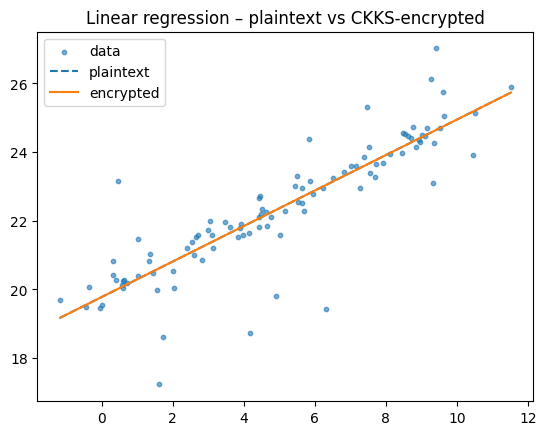

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tenseal as ts

x, y = np.loadtxt("data_nda.csv")
n = len(x)
a_ref, b_ref = np.polyfit(x, y, 1)

ctx = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=2**14,
    coeff_mod_bit_sizes=[60, 50, 50, 50, 60],
)
ctx.global_scale = 2**50
ctx.generate_galois_keys()

ex = ts.ckks_vector(ctx, x.tolist())
ey = ts.ckks_vector(ctx, y.tolist())
exx, exy = ex * ex, ex * ey

Sx  = ex.sum().decrypt()[0]
Sy  = ey.sum().decrypt()[0]
Sxx = exx.sum().decrypt()[0]
Sxy = exy.sum().decrypt()[0]

den = n * Sxx - Sx**2
a_enc = (n * Sxy - Sx * Sy) / den
b_enc = (Sy - a_enc * Sx) / n

print("encrypted [a, b]:", [a_enc, b_enc])
print("plaintext [a, b]:", [a_ref, b_ref])

t = np.linspace(x.min(), x.max(), 200)
plt.scatter(x, y, s=10, alpha=0.6, label="data")
plt.plot(t, a_ref * t + b_ref, "--", label="plaintext")
plt.plot(t, a_enc * t + b_enc, label="encrypted")
plt.legend()
plt.title("Linear regression – plaintext vs CKKS-encrypted")
plt.show()

**Powtórka z regresji liniowej prostej**

W przypadku regresji liniowej prostej (tzn. jedna zmienna niezależna, jedna zmienna zależna) współczynniki $a$ i $b$ prostej regresji dane są jawnymi wzorami. Niech $x$ będzie zmienną niezależną o wartościach $(x_1,...,x_n)$, a $y$ będzie zmienną zależną o wartościach $(y_1,...,y_n)$ odpowiadających kolejnym wartościom $x$. Wtedy współczynniki $a$ i $b$ prostej $y=ax+b$ minimalizującej sumę kwadratów błędów dane są wzorami:

$$a=\frac{n\sum_{i=1}^n x_i y_i - \sum_{i=1}^n x_i\sum_{i=1}^n y_i}{n\sum_{i=1}^n x_i^2- \left(\sum_{i=1}^n x_i\right)^2}$$

$$b=\frac{\sum_{i=1}^ny_i\sum_{i=1}^n x_i^2 - \sum_{i=1}^n x_i\sum_{i=1}^n x_i y_i}{n\sum_{i=1}^n x_i^2- \left(\sum_{i=1}^n x_i\right)^2}$$

In [10]:
den = n * Sxx - Sx**2 

a = (n * Sxy - Sx * Sy) / den
b = (Sy * Sxx - Sx * Sxy) / den

print("a (slope) :", a)
print("b (intercept):", b)

a (slope) : 0.516488759788251
b (intercept): 19.7802230254872
